<a href="https://colab.research.google.com/github/susanemiliaw/NTHU_2025_DLIA_HW/blob/main/SUSAN_HW2_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Access the file stored in drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
# Access files and prepare dataset (upload from local)
from google.colab import drive
drive.mount('/content/drive')

import os
from google.colab import files
import zipfile

# Upload the main zip file from your computer (114-artificial-intelligence-hw-2.zip)
print("Please upload your dataset zip file (e.g., 114-artificial-intelligence-hw-2.zip)")
uploaded = files.upload()

# Extract it
zip_name = list(uploaded.keys())[0]
extract_dir = '/content/dataset'
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
import os, glob

extract_dir = '/content/dataset'

print("Top-level after unzip:", os.listdir(extract_dir))

train_candidates = glob.glob(os.path.join(extract_dir, '**', 'trainset', 'trainset'), recursive=True)
test_candidates  = glob.glob(os.path.join(extract_dir, '**', 'testset', 'testset'),  recursive=True)

if not train_candidates or not test_candidates:
    # fallback: mungkin hanya 1 tingkat (…/trainset/*class-folders*)
    train_candidates = train_candidates or glob.glob(os.path.join(extract_dir, '**', 'trainset'), recursive=True)
    test_candidates  = test_candidates  or glob.glob(os.path.join(extract_dir, '**', 'testset'),  recursive=True)

# Ambil kandidat pertama yang valid
def pick_valid_dir(cands, expect_classes=True):
    for d in cands:
        if os.path.isdir(d):
            try:
                lst = os.listdir(d)
                if lst:  # ada isi
                    return d
            except Exception:
                pass
    return None

train_dir = pick_valid_dir(train_candidates)
test_dir  = pick_valid_dir(test_candidates)

print("Resolved train_dir:", train_dir)
print("Resolved test_dir :", test_dir)

# Validasi akhir
assert train_dir and os.path.isdir(train_dir), "train_dir not found"
assert test_dir  and os.path.isdir(test_dir),  "test_dir not found"

print("Trainset folders (first 8):", os.listdir(train_dir)[:8])
print("Testset samples (first 8):", os.listdir(test_dir)[:8])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Please upload your dataset zip file (e.g., 114-artificial-intelligence-hw-2.zip)


Saving 114-artificial-intelligence-hw-2.zip to 114-artificial-intelligence-hw-2 (2).zip
Top-level after unzip: ['testset', 'submission_sample.csv', 'trainset']
Resolved train_dir: /content/dataset/trainset/trainset
Resolved test_dir : /content/dataset/testset/testset
Trainset folders (first 8): ['Random', 'Scratch', 'Center', 'Near-full', 'Donut', 'Edge-Ring', 'Edge-Loc', 'Loc']
Testset samples (first 8): ['4583.jpg', '2863.jpg', '6216.jpg', '1597.jpg', '7271.jpg', '6193.jpg', '6995.jpg', '3247.jpg']


In [14]:
# Import essential libraries
import os, random, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from collections import Counter

# Torch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, models
from torchvision.utils import make_grid

# Utils
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

# Clean logs
warnings.filterwarnings("ignore")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [15]:
#Device setup
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    print(f'GPU detected: {gpu_name}')
else:
    device = torch.device('cpu')
    print('Running on CPU — training may be slower.')

# Double-check current device
print('Using device:', device)

GPU detected: Tesla T4
Using device: cuda


In [16]:
# Hyperparameters
NUM_EPOCHS = 15
BATCH_SIZE = 32
LR = 1e-3
VAL_RATIO = 0.2          # 80% training, 20% validation split

# quick summary
print(f"Epochs: {NUM_EPOCHS}, Batch size: {BATCH_SIZE}, LR: {LR}, Val split: {VAL_RATIO}")


Epochs: 15, Batch size: 32, LR: 0.001, Val split: 0.2


In [17]:
# Dataset directories
import os

# Path hasil ekstraksi otomatis
train_dir = '/content/dataset/trainset/trainset'
test_dir  = '/content/dataset/testset/testset'

print("Train directory:", train_dir)
print("Test directory :", test_dir)

# Quick existence check
for d in [train_dir, test_dir]:
    print(f"{d} ->", "Found" if os.path.exists(d) else "Not found")


Train directory: /content/dataset/trainset/trainset
Test directory : /content/dataset/testset/testset
/content/dataset/trainset/trainset -> Found
/content/dataset/testset/testset -> Found


In [18]:
# Image transformations
from torchvision import transforms

IMG_SIZE = 224

# Transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Transformations for validation/test (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


### Load all the data

In [19]:
#Load all the data
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from collections import Counter
import math

# Pastikan direktori benar
print("Train dir:", train_dir)
print("Test dir :", test_dir)

# Load full dataset dengan transformasi training
full_dataset = ImageFolder(root=train_dir, transform=train_transform)

# info kelas
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"\nDetected {num_classes} classes:\n{class_names}")

# Split train/validation
VAL_RATIO = 0.2
val_size = int(len(full_dataset) * VAL_RATIO)
train_size = len(full_dataset) - val_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

# pastikan val_set pakai test_transform (tanpa augmentasi)
val_set.dataset.transform = test_transform

# Dataloader setup
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

#Loader kecil untuk visualisasi (optional)
vis_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=1)

print(f"\nTrain samples: {train_size}, Validation samples: {val_size}")

# Cek keseimbangan kelas
label_counts = Counter(full_dataset.targets)
print("\nClass counts (full dataset):")
for idx, cls in enumerate(class_names):
    print(f"{cls:12s}: {label_counts[idx]}")

Train dir: /content/dataset/trainset/trainset
Test dir : /content/dataset/testset/testset

Detected 8 classes:
['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']

Train samples: 14100, Validation samples: 3525

Class counts (full dataset):
Center      : 3462
Donut       : 409
Edge-Loc    : 2417
Edge-Ring   : 8554
Loc         : 1620
Near-full   : 54
Random      : 609
Scratch     : 500


### Information of dataset

In [20]:
# Information of dataset
from PIL import Image
import numpy as np
from collections import Counter
import numpy as np

# Peek one sample
sample_path, sample_y = full_dataset.samples[0]
im = Image.open(sample_path)
print("Example path:", sample_path)
print("PIL mode:", im.mode, "| size (W,H):", im.size)

img_array = np.array(im)
print("Array shape (H,W,C or H,W):", img_array.shape)

#Quick scan over a subset to check modes & sizes
modes_counter = Counter()
sizes_counter = Counter()

# scan ~200 sampel tersebar merata
idxs = np.linspace(0, len(full_dataset) - 1, num=min(200, len(full_dataset)), dtype=int)
for i in idxs:
    p, _ = full_dataset.samples[i]
    with Image.open(p) as img:
        modes_counter[img.mode] += 1
        sizes_counter[img.size] += 1

print("\nSampled image modes:", dict(modes_counter))
print("Most common sizes:", sizes_counter.most_common(5))

#  Reminder tindakan bila ada non-RGB
if any(m != "RGB" for m in modes_counter.keys()):
    print("\n Detected non-RGB images. Recommended to add this at the TOP of both transforms:")
    print("    transforms.Lambda(lambda im: im.convert('RGB'))")
else:
    print("\n All sampled images are RGB.")


Example path: /content/dataset/trainset/trainset/Center/0.jpg
PIL mode: RGB | size (W,H): (50, 39)
Array shape (H,W,C or H,W): (39, 50, 3)

Sampled image modes: {'RGB': 200}
Most common sizes: [((27, 25), 33), ((36, 38), 20), ((52, 53), 17), ((62, 63), 11), ((41, 41), 7)]

 All sampled images are RGB.


Classes: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']
class_to_idx: {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Near-full': 5, 'Random': 6, 'Scratch': 7}
First sample path: /content/dataset/trainset/trainset/Center/0.jpg
First sample label_id: 0 | label_name: Center

Class counts:
Center      : 3462
Donut       : 409
Edge-Loc    : 2417
Edge-Ring   : 8554
Loc         : 1620
Near-full   : 54
Random      : 609
Scratch     : 500


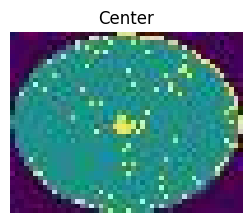

PIL type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [21]:
# Dataset summary & sample preview
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt

# Daftar kelas & mapping index
print("Classes:", full_dataset.classes)
print("class_to_idx:", full_dataset.class_to_idx)

# Contoh item pertama (path, label_id, label_name)
first_path, first_label = full_dataset.samples[0]
print("First sample path:", first_path)
print("First sample label_id:", first_label, "| label_name:", full_dataset.classes[first_label])

# Hitung distribusi kelas (pakai target dari full_dataset)
counts = Counter(full_dataset.targets)
print("\nClass counts:")
for cls, idx in full_dataset.class_to_idx.items():
    print(f"{cls:12s}: {counts[idx]}")

# Tampilkan gambar contoh
im = Image.open(first_path)
plt.figure(figsize=(3,3))
plt.imshow(im)
plt.axis("off")
plt.title(full_dataset.classes[first_label])
plt.show()

print("PIL type:", type(im))


### Plot different types of surface defect


In [22]:
# Visualization helpers
import matplotlib.pyplot as plt
import math
from torchvision.datasets import ImageFolder

# inverse-normalize: dari [-1,1] balik ke [0,1]
def denorm(t):
    # kita pakai Normalize(mean=0.5, std=0.5) => inverse: x*0.5 + 0.5
    return (t * 0.5 + 0.5).clamp(0, 1)

def visualize_batch(batch, classes, dataset_type="train"):
    """Show up to 8 images from a (images, labels) batch tuple."""
    imgs, labels = batch
    n = min(len(imgs), 8)
    rows, cols = 2, 4  # 8 classes => 2x4 grid

    plt.figure(figsize=(12, 6))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        img = denorm(imgs[i]).permute(1, 2, 0).cpu().numpy()
        lbl = classes[int(labels[i])]
        plt.imshow(img)
        plt.title(lbl, fontsize=10)
        plt.axis("off")
    plt.suptitle(f"{dataset_type} batch", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

def visualize_one_per_class(dataset, classes):
    """Scan dataset and show one sample per class (2x4 grid)."""
    # kumpulkan satu contoh per class_id
    seen = {}
    for i in range(len(dataset)):
        img, y = dataset[i]
        if y not in seen:
            seen[y] = img
        if len(seen) == len(classes):
            break

    rows, cols = 2, 4
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(classes):
        ax = plt.subplot(rows, cols, i + 1)
        img = denorm(seen[i]).permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.title(class_name, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

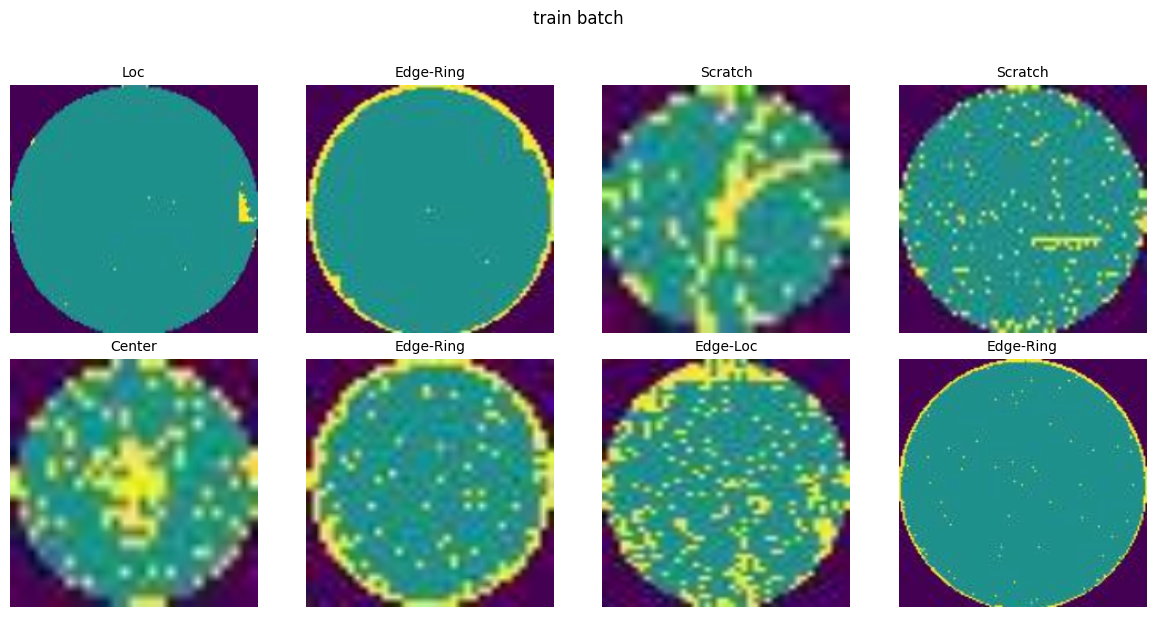

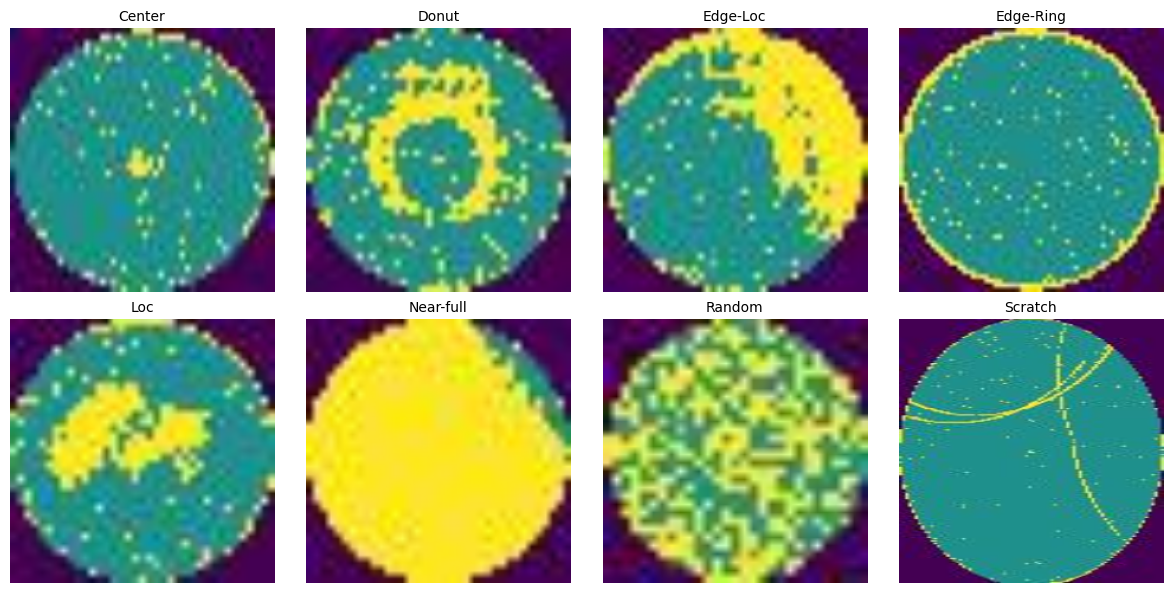

In [23]:
# dataset khusus visual (pakai test_transform tanpa augmentasi)
vis_dataset = ImageFolder(root=train_dir, transform=test_transform)
vis_loader  = DataLoader(vis_dataset, batch_size=8, shuffle=True, num_workers=1)

# Visualize batch
batch = next(iter(vis_loader))
visualize_batch(batch, class_names, dataset_type="train")

# Visualize satu gambar per kelas
visualize_one_per_class(vis_dataset, class_names)


### Define the CNN architecture
Tips:
- try different size of out_channels/ conv layer/ kernel

In [25]:
# === Define CNN model (MobileNetV3/ResNet18) ===
import torch.nn as nn
from torchvision.models import (
    mobilenet_v3_small, MobileNet_V3_Small_Weights,
    resnet18, ResNet18_Weights
)

MODEL_NAME     = "mobilenetv3"
USE_PRETRAINED = True

# class imbalance → weighted loss
# gunakan label_counts dari blok "Load all the data"
counts = np.array([label_counts[i] for i in range(num_classes)], dtype=np.float32)
cls_weights = (counts.max() / counts)
cls_weights = torch.tensor(cls_weights, dtype=torch.float32, device=device)

if MODEL_NAME == "mobilenetv3":
    weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1 if USE_PRETRAINED else None
    model = mobilenet_v3_small(weights=weights)
    in_feats = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_feats, num_classes)

elif MODEL_NAME == "resnet18":
    weights = ResNet18_Weights.IMAGENET1K_V1 if USE_PRETRAINED else None
    model = resnet18(weights=weights)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)

else:
    raise ValueError("Unknown MODEL_NAME")

model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=cls_weights)  # handle imbalance (Near-full sangat sedikit)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# ringkasan singkat
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {MODEL_NAME} | pretrained={USE_PRETRAINED}")
print(f"Params: {trainable_params/1e6:.2f}M trainable / {total_params/1e6:.2f}M total")
print("Class weights:", cls_weights.detach().cpu().numpy())


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 146MB/s]

Model: mobilenetv3 | pretrained=True
Params: 1.53M trainable / 1.53M total
Class weights: [  2.4708261  20.914425    3.539098    1.          5.2802467 158.40741
  14.045977   17.108    ]


In [26]:
#Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(weight=cls_weights).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# Cosine schedule across NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Mixed precision (speeds up on GPU, safe on CPU -> disabled automatically)
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print("AMP:", use_amp)

AMP: True


In [27]:
#  Training loop: train + validation, AMP, save best
from tqdm.auto import tqdm

def accuracy_from_logits(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

best_val_acc = 0.0
best_path = os.path.join(BASE_DIR, "best_wafer_model.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    # ----- Train -----
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [train]"):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = model(xb)
            loss = criterion(out, yb)

        scaler.scale(loss).xpu if False else None  # no-op to avoid warnings
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        train_acc  += accuracy_from_logits(out, yb)

    train_loss /= len(train_loader)
    train_acc  /= len(train_loader)

    #  Validate
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [val]"):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            val_acc  += accuracy_from_logits(out, yb)

    val_loss /= len(val_loader)
    val_acc  /= len(val_loader)

    # scheduler step (after val for cosine works fine)
    scheduler.step()

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(),
                    'class_names': class_names,
                    'model_name': MODEL_NAME}, best_path)
        print(f"Saved new best to {best_path} (val_acc={best_val_acc:.4f})")

print("Finished Training. Best val_acc:", best_val_acc)


Epoch 1/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 1/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 01 | train_loss=0.4966, train_acc=0.8812 | val_loss=0.3254, val_acc=0.9414
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9414)


Epoch 2/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 2/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 02 | train_loss=0.2069, train_acc=0.9505 | val_loss=0.2096, val_acc=0.9333


Epoch 3/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 3/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 03 | train_loss=0.1405, train_acc=0.9630 | val_loss=0.4087, val_acc=0.9465
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9465)


Epoch 4/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a12abdfba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x79a12abdfba0>^^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^^^self._shutdown_workers()^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

               ^  ^ ^^^^^^^^^^^^^^^^^^^^
  

Epoch 4/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.1155, train_acc=0.9694 | val_loss=0.1406, val_acc=0.9628
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9628)


Epoch 5/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 5/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.1471, train_acc=0.9701 | val_loss=0.1722, val_acc=0.9544


Epoch 6/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 6/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 06 | train_loss=0.0792, train_acc=0.9796 | val_loss=0.1786, val_acc=0.9699
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9699)


Epoch 7/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 7/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 07 | train_loss=0.0427, train_acc=0.9876 | val_loss=0.1311, val_acc=0.9707
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9707)


Epoch 8/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 8/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a12abdfba0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x79a12abdfba0>self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

       self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
^ ^^ ^ ^ ^ ^ ^^ ^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^^  ^^ ^ ^ 
   File "/usr/lib

Epoch 08 | train_loss=0.0296, train_acc=0.9906 | val_loss=0.1653, val_acc=0.9744
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9744)


Epoch 9/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 9/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 09 | train_loss=0.0153, train_acc=0.9939 | val_loss=0.1332, val_acc=0.9752
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9752)


Epoch 10/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 10/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.0084, train_acc=0.9963 | val_loss=0.1562, val_acc=0.9744


Epoch 11/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 11/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 11 | train_loss=0.0043, train_acc=0.9980 | val_loss=0.1455, val_acc=0.9764
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9764)


Epoch 12/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 12/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 12 | train_loss=0.0045, train_acc=0.9980 | val_loss=0.1353, val_acc=0.9769
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9769)


Epoch 13/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a12abdfba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x79a12abdfba0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():  
        ^ ^ ^^ ^^ ^^^^^^^^^^^^^^^^^^^

Epoch 13/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 13 | train_loss=0.0021, train_acc=0.9991 | val_loss=0.1424, val_acc=0.9766


Epoch 14/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 14/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 14 | train_loss=0.0017, train_acc=0.9988 | val_loss=0.1436, val_acc=0.9786
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9786)


Epoch 15/15 [train]:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch 15/15 [val]:   0%|          | 0/111 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.0010, train_acc=0.9998 | val_loss=0.1456, val_acc=0.9789
Saved new best to /content/drive/MyDrive/IntrotoAI/best_wafer_model.pth (val_acc=0.9789)
Finished Training. Best val_acc: 0.9788851351351351


In [28]:
# Save final model
import os, torch

final_model_path = os.path.join(BASE_DIR, "HW2_final_model.pth")

torch.save({
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'scheduler_state': scheduler.state_dict(),
    'class_names': class_names,
    'model_name': MODEL_NAME,
    'num_epochs': NUM_EPOCHS,
    'best_val_acc': best_val_acc
}, final_model_path)

print(f"Final model saved to: {final_model_path}")


Final model saved to: /content/drive/MyDrive/IntrotoAI/HW2_final_model.pth


In [29]:
#Load trained model for inference ===

# Path ke model yang mau diuji (bisa 'best_wafer_model.pth' atau 'HW2_final_model.pth')
PATH = os.path.join(BASE_DIR, "HW2_final_model.pth")

# checkpoint
checkpoint = torch.load(PATH, map_location=device)

# Buat ulang arsitektur model sesuai nama yang disimpan
if checkpoint.get("model_name") == "mobilenetv3":
    model_test = torchvision.models.mobilenet_v3_small()
    in_feats = model_test.classifier[-1].in_features
    model_test.classifier[-1] = nn.Linear(in_feats, len(checkpoint["class_names"]))
elif checkpoint.get("model_name") == "resnet18":
    model_test = torchvision.models.resnet18()
    in_feats = model_test.fc.in_features
    model_test.fc = nn.Linear(in_feats, len(checkpoint["class_names"]))
else:
    raise ValueError("Unknown model name in checkpoint")

# Muat bobot
model_test.load_state_dict(checkpoint["model_state"])
model_test = model_test.to(device)
model_test.eval()

# Info cepat
print(f"Loaded model from: {PATH}")
print(f"Architecture: {checkpoint.get('model_name')}")
print(f"Classes: {checkpoint['class_names']}")


Loaded model from: /content/drive/MyDrive/IntrotoAI/HW2_final_model.pth
Architecture: mobilenetv3
Classes: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']


In [30]:
# ==Inference & Submission (batched) =
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader  # PIL loader

# pakai class_names dari checkpoint (hyphen-style, sudah cocok submission)
submit_classes = checkpoint["class_names"]

# Dataset test: baca semua *.jpg dan ambil ID dari nama file (e.g., "1234.jpg" -> 1234)
class TestFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.paths = [p for p in os.listdir(root) if p.lower().endswith(".jpg")]
        # urutkan berdasarkan angka ID di filename
        self.ids = sorted([int(os.path.splitext(p)[0]) for p in self.paths])
        # bangun kembali path sesuai urutan ID
        self.paths = [os.path.join(root, f"{i}.jpg") for i in self.ids]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = default_loader(path)  # PIL Image
        if test_transform is not None:
            img = test_transform(img)
        # return tensor dan ID (int)
        img_id = int(os.path.splitext(os.path.basename(path))[0])
        return img, img_id

# DataLoader
test_ds = TestFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

model_test.eval()
pred_rows = []

with torch.no_grad():
    for xb, ids in tqdm(test_loader, desc="Predicting test"):
        xb = xb.to(device, non_blocking=True)
        logits = model_test(xb)
        preds = logits.argmax(1).cpu().tolist()
        pred_rows.extend([(int(i), submit_classes[p]) for i, p in zip(ids, preds)])

# Pastikan urut by ID dan buat submission
pred_rows.sort(key=lambda x: x[0])
submission = pd.DataFrame(pred_rows, columns=["ID", "Category"])

# Simpan ke Drive agar aman
sub_path = os.path.join(BASE_DIR, "submission.csv")
submission.to_csv(sub_path, index=False)
print(f"Submission saved: {sub_path}")
print(submission.head())


Predicting test:   0%|          | 0/124 [00:00<?, ?it/s]

Submission saved: /content/drive/MyDrive/IntrotoAI/submission.csv
   ID  Category
0   0    Random
1   1       Loc
2   2       Loc
3   3  Edge-Loc
4   4  Edge-Loc


In [31]:
# Save final submission file
import pandas as pd
import os

# Pastikan file submission dari inference sebelumnya sudah ada
sub_path = os.path.join(BASE_DIR, "submission.csv")

# Buka untuk konfirmasi isi & ukuran
df_ans = pd.read_csv(sub_path)
print(f"Loaded submission with shape {df_ans.shape}")
print(df_ans.head())

# Simpan juga salinannya di runtime (jika mau download langsung dari Colab)
local_copy = "/content/mySubmission.csv"
df_ans.to_csv(local_copy, index=False)
print(f"Submission file saved to: {local_copy}")

# (Opsional) buat link langsung untuk download
from google.colab import files
files.download(local_copy)


Loaded submission with shape (7894, 2)
   ID  Category
0   0    Random
1   1       Loc
2   2       Loc
3   3  Edge-Loc
4   4  Edge-Loc
Submission file saved to: /content/mySubmission.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Some tips for getting better result
- image size (pick the best suitable size to input)
- different CNN architecture
- data augmentation
- reasonable hyperparameter tuning strategy

In [32]:
#Inference with Test-Time Augmentation (TTA)
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader  # PIL loader

# pastikan model_test, device, BASE_DIR, test_dir, test_transform, checkpoint sudah ada
submit_classes = checkpoint["class_names"]

class TestFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # ambil semua nama file .jpg -> urutkan berdasarkan ID angka
        ids = [int(os.path.splitext(p)[0]) for p in os.listdir(root) if p.lower().endswith(".jpg")]
        self.ids = sorted(ids)
        self.paths = [os.path.join(root, f"{i}.jpg") for i in self.ids]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = default_loader(path)           # PIL Image
        if self.transform is not None:
            img = self.transform(img)       # tensor [C,H,W]
        img_id = int(os.path.splitext(os.path.basename(path))[0])
        return img, img_id

# DataLoader test
test_ds = TestFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# ---- TTA helper: rata-rata logits dari beberapa augment ringan ----
import torch

def tta_logits(model, x):
    # x: [B,C,H,W]
    xs = [
        x,
        torch.flip(x, dims=[-1]),            # horizontal flip
        torch.flip(x, dims=[-2]),            # vertical flip
        torch.rot90(x, 1, dims=[-2, -1]),    # rotate 90
        torch.rot90(x, 3, dims=[-2, -1])     # rotate 270
    ]
    out = 0
    with torch.no_grad():
        for xi in xs:
            out = out + model(xi)
    return out / len(xs)

# Predict dengan TTA
model_test.eval()
pred_rows = []

with torch.no_grad():
    for xb, ids in tqdm(test_loader, desc="Predicting test (TTA)"):
        xb = xb.to(device, non_blocking=True)
        logits = tta_logits(model_test, xb)
        preds = logits.argmax(1).cpu().tolist()
        pred_rows.extend([(int(i), submit_classes[p]) for i, p in zip(ids, preds)])

# Buat submission & simpan
pred_rows.sort(key=lambda x: x[0])
submission_tta = pd.DataFrame(pred_rows, columns=["ID", "Category"])

sub_path_drive = os.path.join(BASE_DIR, "submission_TTA.csv")
submission_tta.to_csv(sub_path_drive, index=False)

sub_path_local = "/content/submission_TTA.csv"
submission_tta.to_csv(sub_path_local, index=False)

print(f"submission_TTA.csv saved to Drive: {sub_path_drive}")
print(submission_tta.head())


Predicting test (TTA):   0%|          | 0/124 [00:00<?, ?it/s]

submission_TTA.csv saved to Drive: /content/drive/MyDrive/IntrotoAI/submission_TTA.csv
   ID  Category
0   0    Random
1   1       Loc
2   2       Loc
3   3  Edge-Loc
4   4  Edge-Loc


In [33]:
from google.colab import files
files.download("/content/submission_TTA.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
#  Oversampling + Label Smoothing (train split only)
from torch.utils.data import WeightedRandomSampler
import numpy as np
import torch.nn as nn

# Ambil target label untuk seluruh dataset
all_targets = np.array(full_dataset.targets, dtype=np.int64)

# Hitung frekuensi kelas & bobot invers (kelas jarang -> bobot besar)
class_freq = np.bincount(all_targets, minlength=num_classes).astype(np.float32)
inv_class_w = class_freq.max() / class_freq  # ex: Near-full kecil -> bobot besar

# Bangun sample weight HANYA untuk indeks train_set (Subset indices)
train_indices = np.array(train_set.indices, dtype=np.int64)
train_sample_weights = inv_class_w[all_targets[train_indices]]

sampler = WeightedRandomSampler(
    weights=torch.from_numpy(train_sample_weights),
    num_samples=len(train_sample_weights),   # satu epoch ~ sama banyaknya dengan train set
    replacement=True
)

# Ganti train_loader pakai sampler (jangan shuffle lagi)
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=2, pin_memory=True
)

# Loss dengan label smoothing (stabil untuk kelas mirip)
criterion = nn.CrossEntropyLoss(weight=cls_weights, label_smoothing=0.10).to(device)

print("✔ Weighted sampler enabled | label_smoothing=0.10")
print("Class freq:", class_freq.astype(int))
print("Inv class weights (for sampler):", np.round(inv_class_w, 2))


✔ Weighted sampler enabled | label_smoothing=0.10
Class freq: [3462  409 2417 8554 1620   54  609  500]
Inv class weights (for sampler): [  2.47  20.91   3.54   1.     5.28 158.41  14.05  17.11]


In [35]:
# Retrain config
NUM_EPOCHS = 10  # retrain singkat; boleh 15–20 kalau waktu cukup

# Re-init optimizer & scheduler (karena strategi training berubah)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Reset best tracker agar menyimpan model terbaik dari retrain ini
best_val_acc = 0.0
best_path = os.path.join(BASE_DIR, "best_wafer_model_retrain.pth")

print("Retrain ready:", NUM_EPOCHS, "| best_path:", best_path)

Retrain ready: 10 | best_path: /content/drive/MyDrive/IntrotoAI/best_wafer_model_retrain.pth


In [36]:
final_model_path = os.path.join(BASE_DIR, "HW2_final_model_retrain.pth")
torch.save({
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'scheduler_state': scheduler.state_dict(),
    'class_names': class_names,
    'model_name': MODEL_NAME,
    'num_epochs': NUM_EPOCHS,
    'best_val_acc': best_val_acc
}, final_model_path)
print("Saved:", final_model_path)


Saved: /content/drive/MyDrive/IntrotoAI/HW2_final_model_retrain.pth


In [38]:
# Simpan best model ke runtime lokal (bisa pindah ke Drive nanti)
best_path = "/content/best_wafer_model_retrain.pth"
torch.save({
    'model_state': model.state_dict(),
    'class_names': class_names,
    'model_name': MODEL_NAME,
    'best_val_acc': best_val_acc
}, best_path)
print("Saved locally:", best_path)


Saved locally: /content/best_wafer_model_retrain.pth


In [39]:
PATH = "/content/best_wafer_model_retrain.pth"
checkpoint = torch.load(PATH, map_location=device)

# build ulang arsitektur & load state (sama seperti block sebelumnya)
if checkpoint.get("model_name") == "mobilenetv3":
    model_test = torchvision.models.mobilenet_v3_small()
    in_feats = model_test.classifier[-1].in_features
    model_test.classifier[-1] = nn.Linear(in_feats, len(checkpoint["class_names"]))
elif checkpoint.get("model_name") == "resnet18":
    model_test = torchvision.models.resnet18()
    in_feats = model_test.fc.in_features
    model_test.fc = nn.Linear(in_feats, len(checkpoint["class_names"]))
else:
    raise ValueError("Unknown model name in checkpoint")

model_test.load_state_dict(checkpoint["model_state"])
model_test = model_test.to(device)
model_test.eval()
submit_classes = checkpoint["class_names"]
print("Loaded for inference:", PATH)


Loaded for inference: /content/best_wafer_model_retrain.pth


In [40]:
sub_path_drive = os.path.join(BASE_DIR, "submission_TTA_retrain.csv")
submission_tta.to_csv(sub_path_drive, index=False)

sub_path_local = "/content/submission_TTA_retrain.csv"
submission_tta.to_csv(sub_path_local, index=False)
print("Saved:", sub_path_drive)

Saved: /content/drive/MyDrive/IntrotoAI/submission_TTA_retrain.csv


In [41]:
from google.colab import files
files.download("/content/submission_TTA_retrain.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>